# Summary

This notebook analyzes the exploration during training time.

# Imports/Setup

In [34]:
from Data import dataset, generator
from Data import utility as data_utility
from Evaluation import utility as eval_utility
from Model import actors, scipy
from Model import utility as model_utility
from Objectives import losses
import os
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from torch_cg.torch_cg import cg_batch

This configuration class is the central control for the analysis.

In [154]:
class Config:
    # singular/tsne
    mat_size = 25
    root_path =  "/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_13"
    
    # residual
    filehead, filetail = 'actor_output_step_', '_0.pth'
    condition_path = "/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_9"
    condition_index = 2498
    critic_cos_path = "/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_8"
    critic_cos_index = -1
    # period 500
    # critic_cond_path = "/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_18"
    # period 75
    critic_cond_path = "/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_13"
    critic_cond_index = -1
    critic_cond_nocos_path = "/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/RUNS_12"
    critic_cond_nocos_index = -1

# Singular Analysis

Look at singular examples.

In [155]:
i, j, k = 2499, 1000, 100
path_1 = os.path.join(Config.root_path, f'actor_output_step_{i}_0.pth')
path_2 = os.path.join(Config.root_path, f'actor_output_step_{j}_0.pth')
path_3 = os.path.join(Config.root_path, f'actor_output_step_{k}_0.pth')

In [156]:
out = torch.load(path_1, weights_only=True)
timestep = out['timestep']
actor_out_1 = out['actor_out']
critic_input_1 = out['critic_input']
actor_loss = out['actor_loss']

out = torch.load(path_2, weights_only=True)
timestep = out['timestep']
actor_out_2 = out['actor_out']
critic_input = out['critic_input']
actor_loss = out['actor_loss']

out = torch.load(path_3, weights_only=True)
timestep = out['timestep']
actor_out_3 = out['actor_out']
critic_input_3 = out['critic_input']
actor_loss = out['actor_loss']

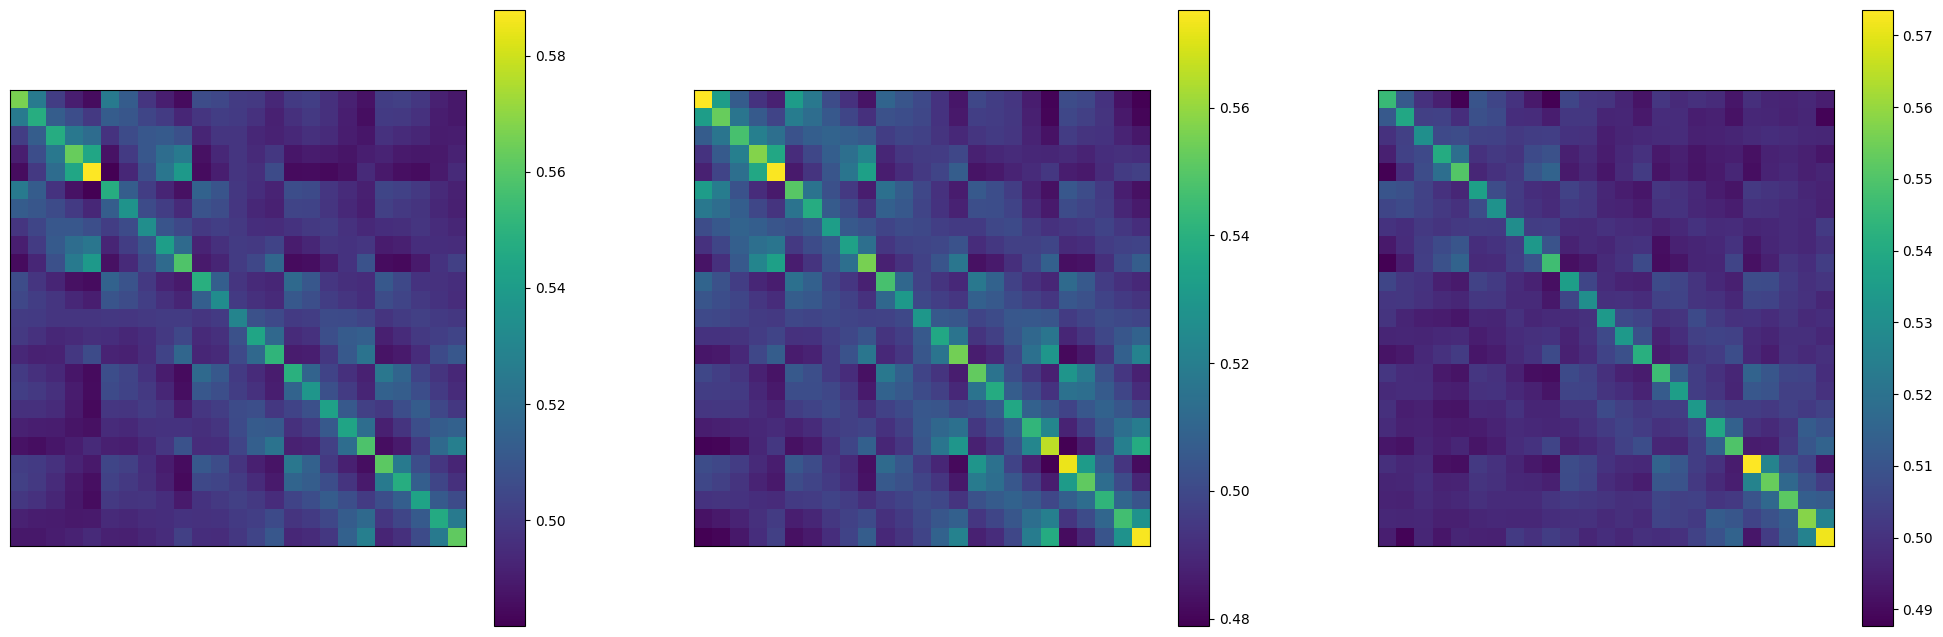

In [158]:
ind = 1

M_1 = actor_out_1.view(32, Config.mat_size, Config.mat_size)
M_2 = actor_out_2.view(32, Config.mat_size, Config.mat_size)
M_3 = actor_out_3.view(32, Config.mat_size, Config.mat_size)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

im1 = ax1.imshow(M_1[ind])
im2 = ax2.imshow(M_2[ind])
im3 = ax3.imshow(M_3[ind])

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.colorbar(im3, ax=ax3)

_ = ax1.set_xticks([])
_ = ax1.set_yticks([])
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax3.set_xticks([])
_ = ax3.set_yticks([])

#plt.savefig('cond_critic_multi_out.png')

0.2004629373550415


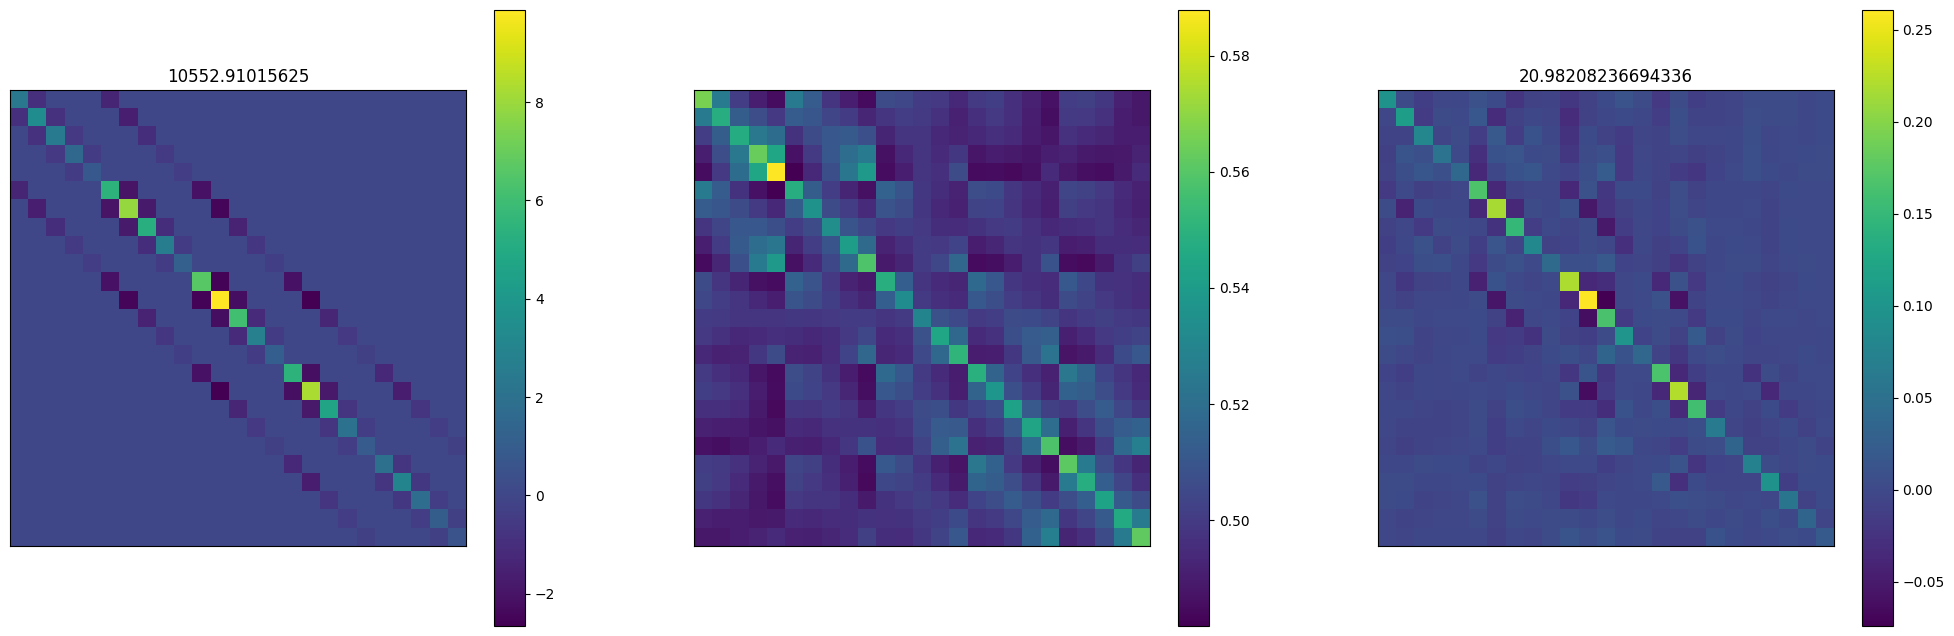

In [161]:
ind = 1

M = actor_out_1[ind].view(Config.mat_size, Config.mat_size)
A = critic_input_1[ind].view(2, Config.mat_size, Config.mat_size)[0]

_, S, _ = torch.linalg.svd(A)
cond = S.max() / S.min()
_, S_pre, _ = torch.linalg.svd(M @ A)
cond_pre = S_pre.max() / S_pre.min()

print(actor_loss)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))

im1 = ax1.imshow(A)
im2 = ax2.imshow(M)
im3 = ax3.imshow(M @ A)

ax1.set_title(f'{cond}')
ax3.set_title(f'{cond_pre}')

plt.colorbar(im1, ax=ax1)
plt.colorbar(im2, ax=ax2)
plt.colorbar(im3, ax=ax3)

_ = ax1.set_xticks([])
_ = ax1.set_yticks([])
_ = ax2.set_xticks([])
_ = ax2.set_yticks([])
_ = ax3.set_xticks([])
_ = ax3.set_yticks([])

#plt.savefig('condition_out.png')

# t-SNE Analysis

Look at exploration of all the different types of models. Look at (condition, condition+critic, and critic) models and their explorative power.

/data/users/jupyter-dam724/RL/precondition-discovery-contextual-bandit/Model/scipy.py:18: SparseEfficiencyWarning: spilu converted its input to CSC format
  ilu = spla.spilu(A, fill_factor)
/data/users/jupyter-dam724/.local/lib/python3.9/site-packages/pyamg/aggregation/aggregation.py:215: SparseEfficiencyWarning: Implicit conversion of A to CSR
  warn('Implicit conversion of A to CSR', SparseEfficiencyWarning)


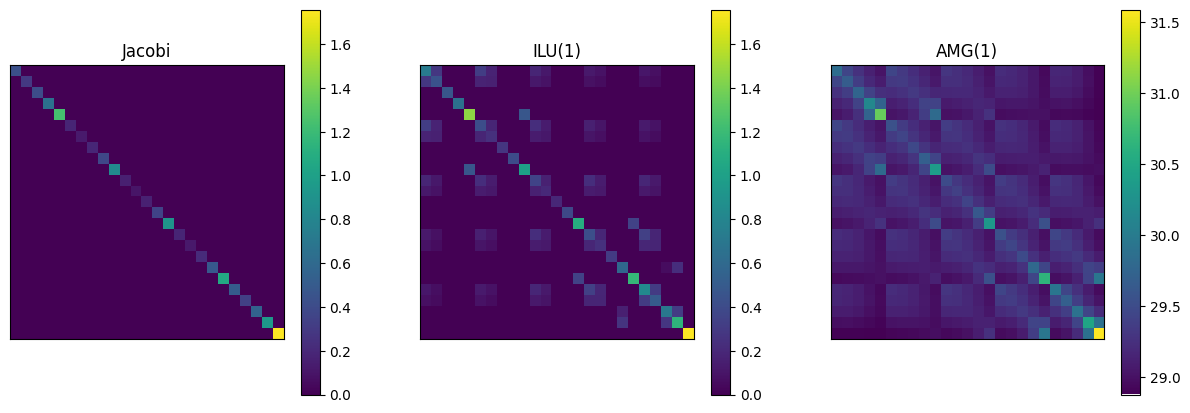

In [162]:
bm = critic_input_1.view(32, 2, Config.mat_size, Config.mat_size)[:, 0].numpy()
trad_precond_params = {
    'batch_matrix': bm, 
    'ind': 1, 
    'fill_factor': 1, 
    'max_levels': 1, 
    'strength': 'classical'
}

jac, ilu, amg = scipy.get_traditional_preconditioners(**trad_precond_params)

In [163]:
ilu = ilu @ np.eye(*ilu.shape)
amg = amg @ np.eye(*amg.shape)

jac = jac / jac.max()
ilu = ilu / ilu.max()
amg = amg / amg.max()

jac = torch.from_numpy(jac)
ilu = torch.from_numpy(ilu)
amg = torch.from_numpy(amg)

In [167]:
def tsne_on_pth_files_a(directory, jac, ilu, amg, output_dim=2, perplexity=30, n_iter=1000, random_state=42, visualize=True):
    data = []
    steps = []  # To store the training steps extracted from filenames
    
    # Load the actor output files
    for filename in os.listdir(directory):
        if filename.startswith("actor_output_step") and filename.endswith(".pth"):
            filepath = os.path.join(directory, filename)
            tensor = torch.load(filepath, weights_only=True)
            img = tensor['actor_out'][0].view(Config.mat_size, Config.mat_size)
            if isinstance(img, torch.Tensor):
                data.append(img.flatten().numpy())  # Flatten the tensor
                step = int(filename.split("_")[3]) 
                steps.append(step)
            else:
                raise ValueError(f"File {filename} does not contain a valid tensor.")
    
    if not data:
        raise ValueError("No valid .pth files found in the directory.")
    
    # Add additional inputs (jac, ilu, amg)
    additional_labels = ["jac", "ilu", "amg"]
    additional_colors = ["black", "orange", "red"]
    for additional_input, label in zip([jac, ilu, amg], additional_labels):
        if isinstance(additional_input, torch.Tensor):
            data.append(additional_input.flatten().numpy())
            steps.append(label)  # Use labels for these special cases
        else:
            raise ValueError(f"Input {label} is not a valid tensor.")
    
    # Convert data and steps to NumPy arrays
    data = np.array(data, dtype=np.float32)
    
    numeric_steps = [step for step in steps if isinstance(step, int)]
    normalized_steps = [
        (step - min(numeric_steps)) / (max(numeric_steps) - min(numeric_steps))
        if isinstance(step, int) else None
        for step in steps
    ] # Normalize numerical steps
    
    # Run t-SNE
    tsne = TSNE(
        n_components=output_dim,
        perplexity=perplexity,
        n_iter=n_iter,
        random_state=1,
        n_jobs=32,
        init='random',
        learning_rate='auto'
    )
    tsne_embeddings = tsne.fit_transform(data)
    
    # Visualization
    if visualize and output_dim == 2:
        plt.figure(figsize=(10, 8))
        
        # Plot the regular data points
        scatter = plt.scatter(
            tsne_embeddings[: len(steps) - 3, 0],
            tsne_embeddings[: len(steps) - 3, 1],
            c=[v for v in normalized_steps if v is not None],  # Use normalized numeric steps
            cmap=cm.viridis,
            s=10,
            alpha=0.8
        )
        plt.colorbar(scatter, label="Training Step")
        
        # Plot the additional inputs (jac, ilu, amg)
        for i, (label, color) in enumerate(zip(additional_labels, additional_colors), start=len(steps) - 3):
            plt.scatter(
                tsne_embeddings[i, 0], tsne_embeddings[i, 1],
                color=color, s=50, alpha=0.8, label=label
            )
        
        plt.title("Condition/Critic, Cosine Schedule (Period 75)")
        plt.xlabel("t-SNE Component 1")
        plt.ylabel("t-SNE Component 2")
        plt.legend(loc='upper left')
        plt.grid(True)
        plt.savefig('cond_critic(75)_extra.png')
        plt.show()
    
    return tsne_embeddings


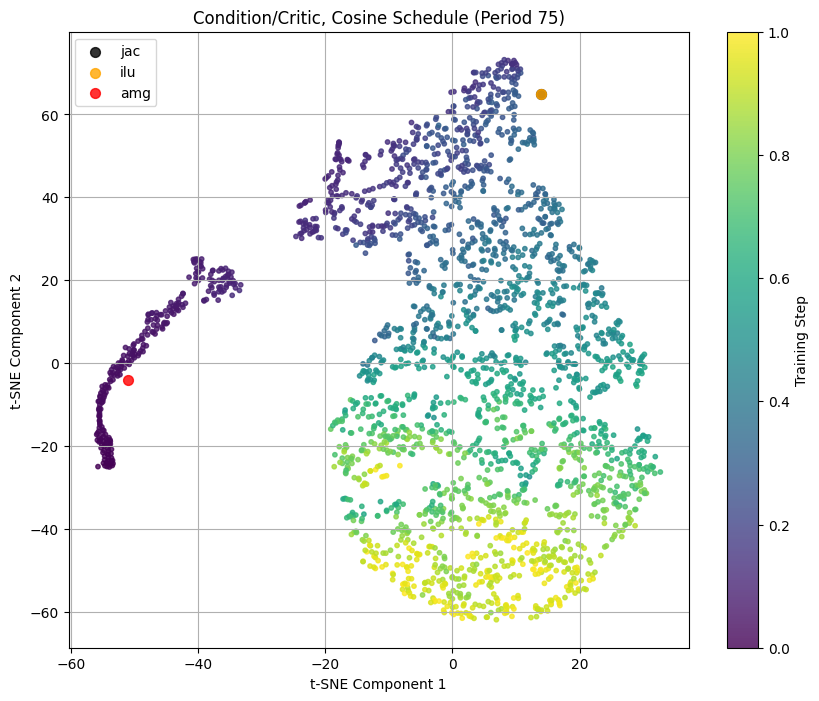

In [168]:
_ = tsne_on_pth_files_a(Config.root_path, jac, ilu, amg)

# Model Comparisons

...

In [150]:
condition = torch.load(
    os.path.join(
        Config.condition_path, 
        Config.filehead + str(2499 if Config.condition_index == -1 else Config.condition_index) + Config.filetail
    ), weights_only=True
)['critic_input'].view(32, 2, Config.mat_size, Config.mat_size)

critic_cos = torch.load(
    os.path.join(
        Config.critic_cos_path, 
        Config.filehead + str(2499 if Config.critic_cos_index == -1 else Config.critic_cos_index) + Config.filetail
    ), weights_only=True
)['critic_input'].view(32, 2, Config.mat_size, Config.mat_size)

critic_cond_nocos = torch.load(
    os.path.join(
        Config.critic_cond_nocos_path, 
        Config.filehead + str(2499 if Config.critic_cond_nocos_index == -1 else Config.critic_cond_nocos_index) + Config.filetail
    ), weights_only=True
)['critic_input'].view(32, 2, Config.mat_size, Config.mat_size)

critic_cond = torch.load(
    os.path.join(
        Config.critic_cond_path, 
        Config.filehead + str(2499 if Config.critic_cond_index == -1 else Config.critic_cond_index) + Config.filetail
    ), weights_only=True
)['critic_input'].view(32, 2, Config.mat_size, Config.mat_size)

systems = [condition, critic_cos, critic_cond_nocos, critic_cond]

In [151]:
A_systems = []
M_systems = []
n_iters_systems = []

for system in systems:
    A_cond = []
    M_cond = []
    n_iters = []

    for indx in range(32):
        b = torch.randn(1, 25, 1)
        A, M = system[indx, 0], system[indx, 1]
        xs = cg_batch(lambda x: torch.matmul(A, x), b, lambda x: torch.matmul(M, x), maxiter=25)
        n_iters.append(xs[1]['niter'])

        _, S, _ = torch.linalg.svd(A)
        A_cond.append(S.max() / S.min())
        _, S_pre, _ = torch.linalg.svd(M @ A)
        M_cond.append(S_pre.max() / S_pre.min())
        
    A_systems.append(A_cond)
    M_systems.append(M_cond)
    n_iters_systems.append(n_iters)
    
A_systems = np.array(A_systems)
M_systems = np.array(M_systems)
n_iters_systems = np.array(n_iters_systems)

In [152]:
np.mean(A_systems, axis=1), np.mean(M_systems, axis=1), np.mean(n_iters_systems, axis=1)

(array([5599.6367, 5943.732 , 6071.7666, 6101.6787], dtype=float32),
 array([1.1149840e+01, 4.0187553e+15, 1.2083391e+01, 1.2143021e+01],
       dtype=float32),
 array([10.1875, 25.    , 10.4375, 10.6875]))

In [153]:
np.std(A_systems, axis=1), np.std(M_systems, axis=1), np.std(n_iters_systems, axis=1)

(array([1642.5483, 2244.6848, 2381.501 , 1986.593 ], dtype=float32),
 array([3.2403073e+00, 1.8782620e+16, 4.7130480e+00, 3.9424515e+00],
       dtype=float32),
 array([1.28543524, 0.        , 1.57990308, 1.46708682]))

# Residual Analysis

Look at solver residuals using varius fit models. The (condition, condition+critic, critic) models in the paper.

*Note: Get A/M from the saved runs. Find A systems with similar scales, around 10k.*

In [1755]:
out = torch.load(
    os.path.join(
        Config.condition_path, 
        Config.filehead + str(2499 if Config.condition_index == -1 else Config.condition_index) + Config.filetail
    ), weights_only=True
)['critic_input'].view(32, 2, Config.mat_size, Config.mat_size)

In [1757]:
b = torch.randn(32, 25, 1)

A, M = out[:, 0], out[:, 1]

xs = cg_batch(lambda x: torch.matmul(A, x), b, lambda x: torch.matmul(M, x), maxiter=25, verbose=True)

 it |       dist   it/s
001 | 3.0555e+01 1496.22
002 | 1.2085e+01 2079.73
003 | 9.5590e+00 2136.73
004 | 3.5978e+00 2167.27
005 | 1.6199e+00 2091.39
006 | 6.5622e-01 2169.24
007 | 3.8566e-01 2199.76
008 | 2.3558e-01 2233.07
009 | 1.2179e-01 2221.26
010 | 4.8756e-02 2311.66
011 | 2.5954e-02 2170.16
012 | 8.7674e-03 2312.34
013 | 3.9261e-03 2314.98
014 | 8.9836e-05 2330.25
015 | -1.0035e-03 2334.08
Terminated in 15 steps (reached maxiter). Took 9.817 ms.


In [1760]:
control = [9.9630e+00, 4.9959e+00, 3.6131e+00, 8.0287e+00, 9.2905e+00, 1.5501e+01, 2.0348e+01, 1.8603e+01, 2.9675e+01, 3.9066e+01, 3.6519e+01, 2.5695e+01, 2.7020e+01, 1.6997e+01, 1.1605e+01, 7.0080e+00, 4.1088e+00, 3.4564e+00, 2.6081e+00, 2.9771e+00, 1.1206e+00, 1.3004e+00, 3.3311e-01, 3.4991e-01, 1.2587e-01]
condition_only = [3.0555e+01,1.2085e+01,9.5590e+00,3.5978e+00,1.6199e+00,6.5622e-01,3.8566e-01,2.3558e-01,1.2179e-01,4.8756e-02,2.5954e-02,8.7674e-03,3.9261e-03,8.9836e-05]
critic_cos = [5.9552e+01, 3.7016e+01, 2.5030e+01, 2.5188e+01, 2.2293e+01, 1.7442e+01, 1.1685e+01, 1.0496e+01, 1.0151e+01, 1.2599e+01, 1.8154e+01, 2.4283e+01, 2.5312e+01, 2.7629e+01, 3.5425e+01, 4.2646e+01, 4.4122e+01, 4.3017e+01, 4.6120e+01, 4.8805e+01, 4.9821e+01, 5.2846e+01, 5.1994e+01, 5.2959e+01, 2.9052e+01]
critic_cond_cos = [2.1196e+01,8.8222e+00,7.7351e+00,2.7404e+00,1.3830e+00,6.9936e-01,4.2495e-01,1.5079e-01,6.8987e-02,3.3711e-02,1.2281e-02,5.2210e-03,1.6857e-04]
critic_cond = [1.7817e+01,1.0195e+01,4.5052e+00,2.3661e+00,1.4432e+00,5.8988e-01,3.8594e-01,2.2055e-01,9.6623e-02,5.6398e-02,1.8503e-02,1.1735e-02,6.0359e-03,8.3307e-04]

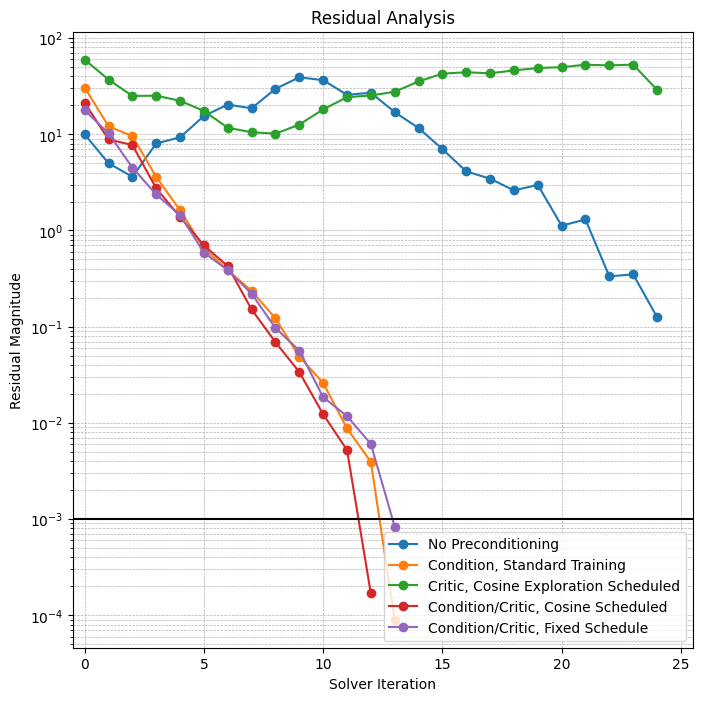

In [1763]:
plt.figure(figsize=(8, 8))

# Create the line plot with dots at the points
plt.plot(control, marker='o', label='No Preconditioning')
plt.plot(condition_only, marker='o', label='Condition, Standard Training')
plt.plot(critic_cos, marker='o', label='Critic, Cosine Exploration Scheduled')
plt.plot(critic_cond_cos, marker='o', label='Condition/Critic, Cosine Scheduled')
plt.plot(critic_cond, marker='o', label='Condition/Critic, Fixed Schedule')

# Set the title and labels
plt.title("Residual Analysis")
plt.xlabel("Solver Iteration")
plt.ylabel("Residual Magnitude")

plt.yscale('log')
plt.xlim(-0.5, 25.5)

plt.axhline(y=1.0e-3, color='black', linestyle='-', linewidth=1.5)

plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='lower right')

# Display the plot
plt.savefig('residual_analysis.png')
plt.show()